# Demo notebook showing arbok functionalities

This is a simple demo notebook containing the core functionalities of arbok

### Importing qm and arbok module

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.simulate.credentials import create_credentials
from qm import SimulationConfig

2023-07-16 20:42:13,778 - qm - INFO     - Starting session: e4aef38f-83b7-4b12-82c2-1ca577cdca46


In [2]:
from arbok.core.sequence import Sequence
from arbok.core.sample import Sample

from arbok.samples.sunshine.readout.other_ST_read import OtherStReadout
from arbok.samples.sunshine.initialization.mixed_down_up_init import (
    MixedDownUpInit
)
from arbok.samples.sunshine.control.smart_Y import SmartY
from arbok.samples.sunshine.control.smart_swap import SmartSwap
from arbok.samples.sunshine.configs.rf2v_config import rf2v_config

### Instanciating Arbok modules

Firstly we instanciate `Sequence` objects describing initialization and readout

In [3]:
sunshine = Sample('sunshine', rf2v_config)

In [4]:
smart_Y = SmartY('smartY')
smart_swap12 = SmartSwap('smartSwap12')
smart_swap23 = SmartSwap('smartSwap32')
duInit = MixedDownUpInit('duInit')
stReadout = OtherStReadout('stReadout')

Added unit_amp successfully!
Added amp successfully!
Added smart_cycles successfully!
Added elements: ['J1']
Added unit_amp successfully!
Added vControl2_J1 successfully!
Added vControlSWAP_J1 successfully!
Added tWait successfully!
Added tSwap successfully!
Added tControlRamp successfully!
Added elements: ['J1']
Added unit_amp successfully!
Added vControl2_J1 successfully!
Added vControlSWAP_J1 successfully!
Added tWait successfully!
Added tSwap successfully!
Added tControlRamp successfully!


Next a `Sample` object is created containing the device config. With this we can create an empty `Sequence` that we will populate with other sequences in the following

In [5]:
CYY = Sequence('CYY', sample = sunshine)
MEAS = Sequence('MEAS', sample = sunshine)

Note how parameters that have already been defined in 'qh' are skipped.

In [6]:
CYY.add_subsequence(smart_swap12)
CYY.add_subsequence(smart_Y)
CYY.add_subsequence(smart_swap23)

In [7]:
MEAS.add_subsequence(duInit)
MEAS.add_subsequence(CYY)
MEAS.add_subsequence(OtherStReadout('stReadout30'))

Hereby the QCoDeS `Parameter`s describing the respective sequenes are referenced
in the containing `Sequence`. Therefore changes in the subsequences take effect 
in the merged sequence

In [8]:
MEAS.CYY.smartSwap12.root_instrument

<Sequence: MEAS>

### Simulating Sequences

The entire sequence can now be simulated. Note that 'tInitLoadMixed' and 'tPreControl' have been reduced for the sake of visibility.

In [9]:
MEAS.CYY.smartY.parent

<Sequence: CYY>

2023-07-16 20:47:09,101 - qm - INFO     - Performing health check
2023-07-16 20:47:09,896 - qm - INFO     - Health check passed
2023-07-16 20:47:10,977 - qm - INFO     - Simulating program


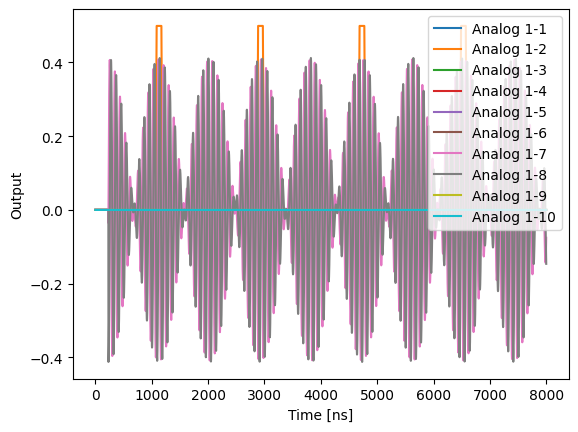

In [19]:
MEAS.CYY.smartSwap12.tWait(int(192))
MEAS.CYY.smartSwap12.run_remote_simulation(duration = 2000)

### Using the `Sequence` in the quantify-core library

In [11]:
import quantify_core.data.handling as dh
from quantify_core.measurement import MeasurementControl

In [12]:
dh.set_datadir(dh.default_datadir())

Data will be saved in:
/home/andi/quantify-data


In [13]:
meas_ctrl = MeasurementControl('meas_ctrl')

In [14]:
import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

In [15]:
#plotmon = pqm.PlotMonitor_pyqt("plotmon")
#insmon = InstrumentMonitor("InstrumentMonitor")
#meas_ctrl.instr_plotmon(plotmon.name)

In [16]:
qb.CNOT.stReadout.vRead_P2()

NameError: name 'qb' is not defined

In [ ]:
meas_ctrl.settables([qb.CNOT.stReadout.vRead_P2, qb.CNOT.stReadout20.vRead_P2])
meas_ctrl.setpoints_grid([
    range(1,300), 
    range(100,300)
])

meas_ctrl.gettables(qb.CNOT.stReadout20.tPreRead)
#dset = meas_ctrl.run(name="Frequency sweep")

Gettables need to be `ParameterWithSetpoints`. This takes an arbitrary amount of 1D setpoint arrays (sizes (n), (m), (k)) and returns (n,m,k) get array.

In [ ]:
qh.parameters.keys()

In [ ]:
readout.read_read.get_raw()

In [ ]:
if {'item':'some'}:
    print("not empty")

In [ ]:
qh.duInit.root_instrument

In [ ]:
qh.stReadout.parent

In [ ]:
qh.instrument_modules

In [ ]:
from qcodes.instrument import InstrumentModule

In [ ]:
im = InstrumentModule('test')

In [ ]:
if []:
    print("true")

In [ ]:
qb.CNOT.duInit.tInitLoadMixed.element

In [ ]:
len(sunshine.config['elements'].keys())


In [ ]:
qb.CNOT.stReadout.elements